### Import Libraries

In [761]:
import numpy as np
import pandas as pd
from ids import IDS
import random
from matplotlib import pyplot as plt

In [839]:
%load_ext autoreload
%autoreload 2
from video import VideoServer, Streamer
from attack import Attacker
import resource_allocation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define Environment

In [1443]:
def generate_attack_intensity(time_steps, baseline, fluctuation, spike_prob, spike_intensity, 
                                             persistence_coeffs, decay_factor, drop_prob, drop_intensity):
    # Initialize intensity array with the first three values set to baseline
    intensity = np.full(time_steps, baseline)
    
    # Generate time series with AR(3) process with decay and drop probability
    for t in range(3, time_steps):
        # AR(3) process with decay factor
        intensity[t] = (
            persistence_coeffs[0] * intensity[t - 1] +
            persistence_coeffs[1] * intensity[t - 2] +
            persistence_coeffs[2] * intensity[t - 3] +
            (1 - sum(persistence_coeffs)) * baseline +
            np.random.normal(0, fluctuation)
        )
        
        # Apply decay factor to gradually reduce intensity toward baseline
        # intensity[t] *= (1 - decay_factor)
        
        # Add random spikes
        if np.random.rand() < spike_prob:
            intensity[t] += spike_intensity
        
        # Randomly drop the intensity with a certain probability
        if np.random.rand() < drop_prob:
            intensity[t] -= drop_intensity
            # Ensure the intensity does not go below zero
            intensity[t] = max(intensity[t], baseline)
        intensity[t] = max(0, intensity[t])

    return intensity

def generate_hsmm(n_steps, states, duration_means, transition_matrix, plot=False):
    def simulate_duration(mean_duration):
        return np.random.poisson(mean_duration)    
    def select_next_state(current_state):
        return np.random.choice(states, p=transition_matrix[states.index(current_state)])

     
    current_state = random.choice(states)  # randomly choose initial state
    state_sequence = [current_state]  # keep track of the states over time
    duration_in_current_state = simulate_duration(duration_means[states.index(current_state)])
    time_in_state = 0  # initialize time spent in the current state
    # Simulate HSMM process with "No Attack" state
    for t in range(1, n_steps):
        if time_in_state < duration_in_current_state:
            # Stay in the current state
            state_sequence.append(current_state)
            time_in_state += 1
        else:
            # Transition to the next state
            current_state = select_next_state(current_state)
            state_sequence.append(current_state)
            duration_in_current_state = simulate_duration(duration_means[states.index(current_state)])
            time_in_state = 1  # Reset time in the new state    
    if plot:
        # Plot the sequence of states over time
        plt.figure(figsize=(20, 3))
        plt.plot(range(n_steps), state_sequence, marker='o')
        plt.yticks(range(len(states)), states)
        plt.title('Hidden Semi-Markov Model')
        plt.xlabel('Time Step')
        plt.ylabel('Attack Variant')
        plt.grid(True)
        plt.show()        

    return state_sequence

In [1555]:
# Use the Solarize Light style globally
plt.style.use("Solarize_Light2")

# Set global parameters for black axes, labels, and grid
plt.rcParams['grid.color'] = 'white'               # Grid color
plt.rcParams['grid.linestyle'] = '--'              # Grid linestyle
plt.rcParams['grid.alpha'] = 0.7                   # Grid transparency
plt.rcParams['axes.edgecolor'] = 'black'           # Axis border color
plt.rcParams['axes.labelcolor'] = 'black'          # Axis label color
plt.rcParams['xtick.color'] = 'black'              # X-axis tick color
plt.rcParams['ytick.color'] = 'black'              # Y-axis tick color
plt.rcParams['text.color'] = 'black'               # Default text color, affects title color

In [1556]:

atk_states = ["NoAtk", "DDoS", "SYN Flood", "HTTP Flood"]
atk_states = ["NoAtk", "bonesi", "goldeneye", "hulk"]
# atk_states = ["NoAtk", "bonesi", "bonesi", "bonesi"]
atk_duration_means = [5, 3, 2, 4]  # mean duration for each state (Poisson distribution)
atk_transition_matrix = np.array([[0.6, 0.1, 0.15, 0.15],  # No Attack
                            [0.3, 0.5, 0.1, 0.1],  # DDoS
                            [0.3, 0.1, 0.5, 0.1],  # SYN Flood
                            [0.3, 0.1, 0.2, 0.4]])  # HTTP Flood   

stream_states = [0, 1] #0: Idle, #1: Streaming
stream_duration_means = [20, 30]  # mean duration for each state (Poisson distribution)
stream_transition_matrix = np.array([[0.3, 0.7],  # Idle
                                     [0.8, 0.2]])  # Streaming
# stream_transition_matrix = np.array([[0.0, 1.0],  # Idle
#                                      [0.0, 1.0]])  # Streaming

# Attack Intensity Parameters
baseline_intensity = 700
fluctuation_intensity = 60
spike_prob = 0.0
spike_intensity = 200
persistence_coeffs = [0.85, 0.15, 0.0]  # Weights for AR(3)
decay_factor = 0.00 # Decay factor to bring intensity down gradually
drop_prob = 0.00  # Probability of a sudden drop in intensity
drop_intensity = 100  # Amount by which intensity drops if drop event occurs

In [1559]:
import numpy as np
class Environment:
    def __init__(self, run_for=100, cpu_capacity = 3.0, seed=4022):
        self.qoe_list = []  # Store QoE values over time
        self.user_count_list = []
        self.cpu_decision_list = []
        self.video_servers_dict = {}
        #TODO Model Streamer Interactions with server (Arrival And Departure)
        self.seed = seed  # Seed for reproducibility
        np.random.seed(self.seed)
        random.seed(self.seed)
        self.cpu_capacity = cpu_capacity
        self.current_timestep = 0  # Initialize timestep counter
        self.run_for = run_for  # Total number of timesteps to simulate
    def initialize_agent(self, num_servers, num_streamers, num_attackers):
        # num_servers=3
        # num_streamers= [6, 6, 6] #Depending on num_server
        # num_attackers= [2, 1, 2] #Depending on num_attackers
        num_streamers = [num_streamers]
        num_attackers = [num_attackers]
        for i in range(num_servers): #Initialize Edge Area Servers
            cpu_capacity = self.cpu_capacity
            streamers = []
            attackers = []
            aggregate_state_sequence = np.zeros(self.run_for)  
            for j in range(num_streamers[i]): #Initialize streamers
                hsmm_states = generate_hsmm(self.run_for, stream_states, stream_duration_means, stream_transition_matrix)

                streamers.append(Streamer(j, hsmm_states))     
                aggregate_state_sequence += hsmm_states
            self.user_count_list = aggregate_state_sequence    
                 
            for j in range(num_attackers[i]): #Initialize Attackers
                hsmm_states = generate_hsmm(self.run_for, atk_states, atk_duration_means, atk_transition_matrix, plot=False)
                intensity_sequence = generate_attack_intensity(
                        self.run_for, baseline_intensity, fluctuation_intensity, spike_prob, spike_intensity,
                        persistence_coeffs, decay_factor, drop_prob, drop_intensity
                )                
                attackers.append(Attacker(j, intensity_sequence, hsmm_states))   
            # Define the Streamer/Attacker-Server Relation on Environment for Task Offloading
            self.video_servers_dict[i] = {
                                          "server": VideoServer(cpu_capacity), 
                                          "streamers": streamers, 
                                          "attackers": attackers, #Attack Workers
                                          }
    def calculate_qoe(self): # Run One Timestep and Calculate QoE
        total_qoe = 0
        num_users = 0
        for _, edge_area in self.video_servers_dict.items():
            cur_server, streamers, attackers = edge_area['server'], edge_area['streamers'], edge_area['attackers']
            for streamer in streamers: #Initiate the Streaming Task
                if streamer.state == 1:
                    streamer.start_stream(cur_server) 
            for attack in attackers: #Initiate the Attack Task
                attack.start(cur_server) #IDS is Called Here
            total_qoe += cur_server.calculate_qoe() 
        average_qoe = total_qoe / len(self.video_servers_dict) 
        self.qoe_list.append(average_qoe)

    def resource_decision(self): #TODO: Change to Control Node
        for _, edge_area in self.video_servers_dict.items():
            server = edge_area['server']
            
            # Retrieve previous intensity and user count
            previous_intensity = server.attack_config_list[0]["old_intensity"]
            previous_user = len(server.active_streamers)
            
            # Get the updated CPU allocation
            updated_cpu = resource_allocation.discrete_approx_decision(previous_intensity, previous_user)
            server.cpu_capacity = updated_cpu['best_cpu']
            
            # Print all relevant information
            print(f"Previous Intensity: {previous_intensity}, Previous User Count: {previous_user}")
            print(f"Updated CPU Allocation: {updated_cpu['best_cpu']}")
                    

    def start_new_timestep(self):
        #? Update Agent
        for _, edge_area in self.video_servers_dict.items():
            edge_area['server'].forward()
            for attack in edge_area['attackers']: #Initiate the Attack Task
                attack.forward() #IDS is Called Here           
            for streamer in edge_area['streamers']:
                streamer.forward()
        self.current_timestep += 1
    def start_new_timestep_controled(self, intensity):
        for _, edge_area in self.video_servers_dict.items():
            edge_area['server'].forward()
            for attack in edge_area['attackers']: #Initiate the Attack Task
                attack.forward_controlled("bonesi", intensity) #IDS is Called Here   
                
            for streamer in edge_area['streamers']:
                streamer.forward()    
                streamer.state = 1

    def update_timestep(self):
        self.calculate_qoe()
        self.resource_decision()
        self.start_new_timestep()
        # self.start_new_timestep_controled()
    
    def plot_qoe(self, ma_window_size = 10):
        def calculate_moving_average(data, window_size=10):
            """
            Calculates the moving average of the given data over a specified window size.
            """
            return np.convolve(data, np.ones(window_size) / window_size, mode='valid')        
        qoe_moving_avg = calculate_moving_average(np.array(self.qoe_list), ma_window_size)
        print("Mean QoE", np.mean(self.qoe_list))
        # Plot QoE and number of users over time
        fig, ax1 = plt.subplots(figsize=(20, 6))

        # Plot QoE
        ax1.set_xlabel("Timestep")
        ax1.set_ylabel("QoE", color="tab:blue")
        ax1.plot(self.qoe_list, label="QoE", color="tab:blue", linewidth=1.5, marker="o")
        ax1.plot(range(ma_window_size-1,len(self.qoe_list)), qoe_moving_avg, label=f"QoE MA {ma_window_size}", color="tab:green", linewidth=3)
        ax1.set_ylim(-0.05,1.05)
        ax1.tick_params(axis="y", labelcolor="tab:green")
        ax1.legend()

        # Create a second y-axis to plot number of users
        ax2 = ax1.twinx()
        ax2.set_ylabel("Number of Active Users", color="tab:orange")
        ax2.plot(self.user_count_list, label="Active Users", color="tab:orange", linewidth=2)
        ax2.tick_params(axis="y", labelcolor="tab:orange")
        ax2.legend()
        
        # Overlay state sequence if provided
        try:
            state_sequence = self.video_servers_dict[0]["attackers"][0].hsmm_state
            ax3 = ax1.twinx()  # Create a third y-axis for state sequence
            ax3.spines["right"].set_position(("outward", 60))  # Offset the third axis
            ax3.set_yticks(range(len(set(state_sequence))))  # Set y-ticks based on unique states
            ax3.set_yticklabels(set(state_sequence), rotation=90)  # Label the states
            
            ax3.plot(state_sequence, label="HSMM States", color="tab:red", marker='o', linestyle='None')
            ax3.set_yticks(range(len(atk_states)))  # Set y-ticks based on the number of states
            ax3.set_yticklabels(atk_states, rotation=90)  # Set the attack state labels
            ax3.set_ylabel("Attack State", color="tab:red")
            ax3.tick_params(axis="y", labelcolor="tab:red")
            ax3.legend(loc="upper center")        

            # Add legends and title
            fig.suptitle("QoE and Number of Active Users Over Time")
            fig.tight_layout()
            plt.legend()
            plt.show()
        except:
            pass
        

    def run(self, intensity=0):
        for _ in range(self.run_for):
            # self.update_timestep()            
            self.calculate_qoe()
            self.start_new_timestep_controled(intensity)            
            if self.current_timestep >= self.run_for-1:
                break         
        print("Simulation Complete.")
        return self.qoe_list

Before 0
Previous Intensity: 0, Previous User Count: 4
Updated CPU Allocation: 5.5
Before 700
After 637.5
Previous Intensity: 700, Previous User Count: 4
Updated CPU Allocation: 4.0
Before 700
After 300.0
Previous Intensity: 700, Previous User Count: 4
Updated CPU Allocation: 4.0
Before 812
After 412.0
Previous Intensity: 812, Previous User Count: 4
Updated CPU Allocation: 3.5
Before 809
After 296.5
Previous Intensity: 809, Previous User Count: 4
Updated CPU Allocation: 3.5
Before 847
After 334.5
Previous Intensity: 847, Previous User Count: 4
Updated CPU Allocation: 3.5
Before 809
After 296.5
Previous Intensity: 809, Previous User Count: 4
Updated CPU Allocation: 3.5
Before 760
After 247.5
Previous Intensity: 760, Previous User Count: 4
Updated CPU Allocation: 4.0
Before 750
After 350.0
Previous Intensity: 750, Previous User Count: 4
Updated CPU Allocation: 4.0
Before 728
After 328.0
Previous Intensity: 728, Previous User Count: 4
Updated CPU Allocation: 4.0
Before 767
After 367.0
Pre

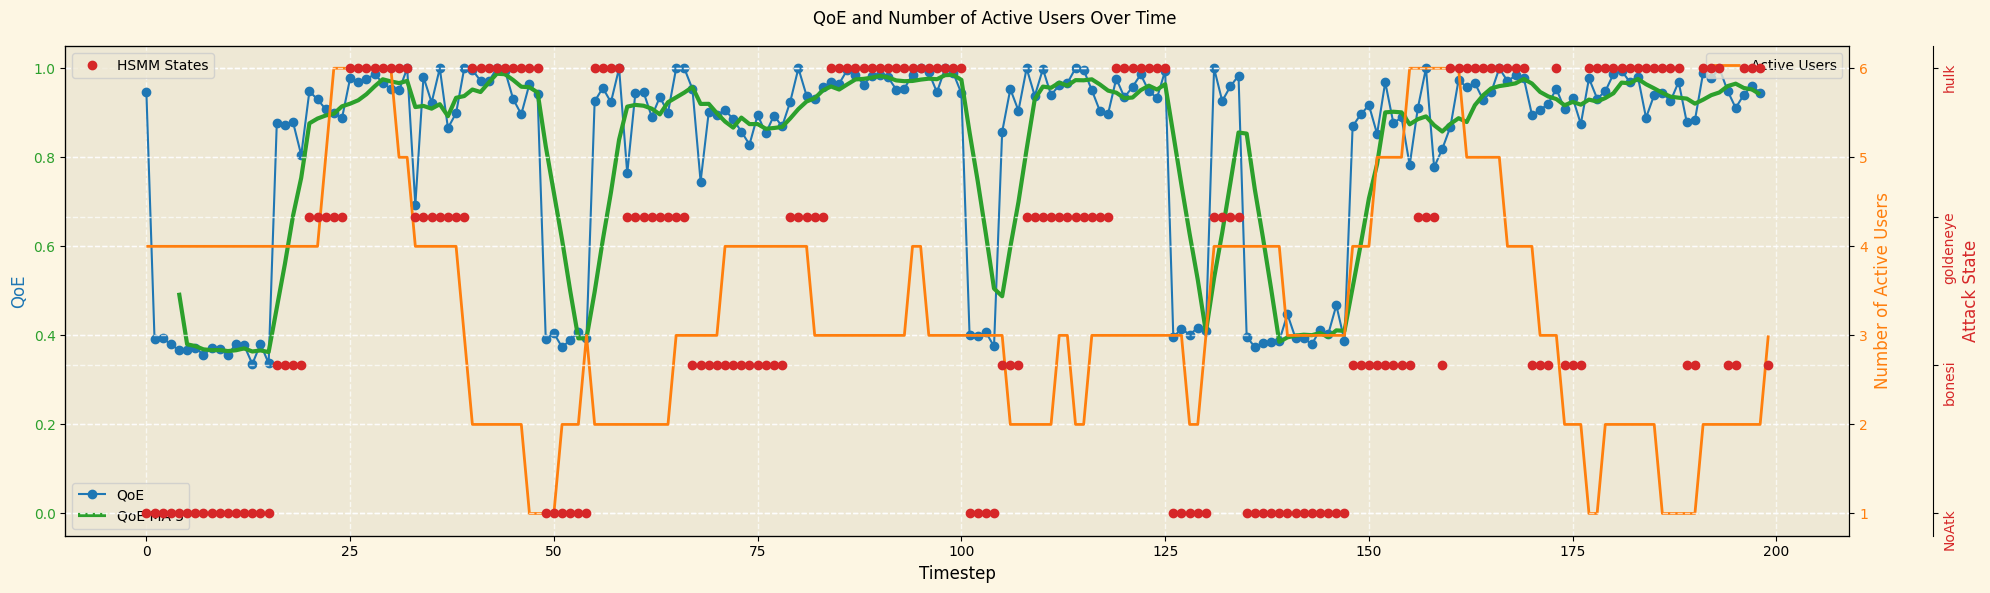

In [1558]:
env = Environment(run_for=200, cpu_capacity = 3.5)
env.initialize_agent(num_servers=1, num_streamers=6, num_attackers=1)
env.run()
env.plot_qoe(ma_window_size=5)


### BaseLine - Discrete Approximation Resource Allocation

Generate the resource allocation dictionary

In [1509]:
# Define parameters for brute-force search
cpu_range = np.arange(0.5, 6.0, 0.5)  # Range of CPU allocations to test
streamer_range = range(0, 7)  # Range of streamer numbers to test (1 to 6)
intensity_min, intensity_max, intensity_interval= 0, 2200, 200  # Continuous range for intensity

# Sample intensities within the continuous range
intensity_samples = np.arange(intensity_min, intensity_max, intensity_interval)

# Dictionary to store the best QoE results
best_results = {}

# Perform brute-force search over CPU, number of streamers, and sampled intensities
for intensity in intensity_samples:
    for n_streamers in streamer_range:
        max_qoe = 0
        best_cpu = 5.5

        for cpu in cpu_range:
            # Initialize the environment for each combination of CPU, streamers, and intensity
            env = Environment(run_for=2, cpu_capacity=cpu)
            env.initialize_agent(num_servers=1, num_streamers=n_streamers, num_attackers=1)
            
            # Run the environment and get the QoE for the current intensity
            cur_qoe = env.run(intensity=intensity)[1]
            
            # Update the maximum QoE and the best CPU allocation if this QoE is higher
            if cur_qoe > max_qoe:
                max_qoe = cur_qoe
                best_cpu = cpu

        # Store the best CPU, max QoE, and intensity for this combination of streamers and intensity
        best_results[(round(intensity, 2), n_streamers)] = {"best_cpu": best_cpu, "max_qoe": max_qoe}

# Display the results
print("Best CPU Allocation for Maximum QoE with Sampled Continuous Intensity:")
for (intensity, n_streamers), result in best_results.items():
    print(f"Intensity: {intensity} | Streamers: {n_streamers} | Best CPU: {result['best_cpu']} | Max QoE: {result['max_qoe']}")

Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
Before 0
B

Convert to Json File

In [1566]:
# Convert dictionary to a JSON-serializable format
best_results_serializable = {
    str(k): {key: float(value) if isinstance(value, np.float64) else value for key, value in v.items()}
    for k, v in best_results.items()
}

# Save the dictionary as a JSON file
# with open("./DARA.json", "w") as file:
#     json.dump(best_results_serializable, file)

In [1567]:
def discrete_approx_decision(intensity, n_streamer):
    with open("DARA.json", "r") as file:
        best_approx_decision_dict = json.load(file)
    closest_intensity = int(intensity/intensity_interval)*intensity_interval
    return best_approx_decision_dict[str((closest_intensity, n_streamer))]
    
discrete_approx_decision(500, 2)['best_cpu']


4.5

Before 0
Before 1000
After 0
Before 0
Before 1000
After 0
Before 0
Before 1000
After 0
Before 0
Before 1000
After 0
Before 0
Before 1000
After 0
Before 0
Before 1000
After 0
Before 0
Before 1000
After 77.5
Before 0
Before 1000
After 280.0
Before 0
Before 1000
After 482.5
Before 0
Before 1000
After 685.0
Before 0
Before 1000
After 887.5
Before 0
Before 1000
After 0
Before 0
Before 1000
After 0
Before 0
Before 1000
After 0
Before 0
Before 1000
After 0
Before 0
Before 1000
After 0
Before 0
Before 1000
After 0
Before 0
Before 1000
After 77.5
Before 0
Before 1000
After 280.0
Before 0
Before 1000
After 482.5
Before 0
Before 1000
After 685.0
Before 0
Before 1000
After 887.5
Before 0
Before 1000
After 0
Before 0
Before 1000
After 0
Before 0
Before 1000
After 0
Before 0
Before 1000
After 0
Before 0
Before 1000
After 0
Before 0
Before 1000
After 0
Before 0
Before 1000
After 77.5
Before 0
Before 1000
After 280.0
Before 0
Before 1000
After 482.5
Before 0
Before 1000
After 685.0
Before 0
Before 100

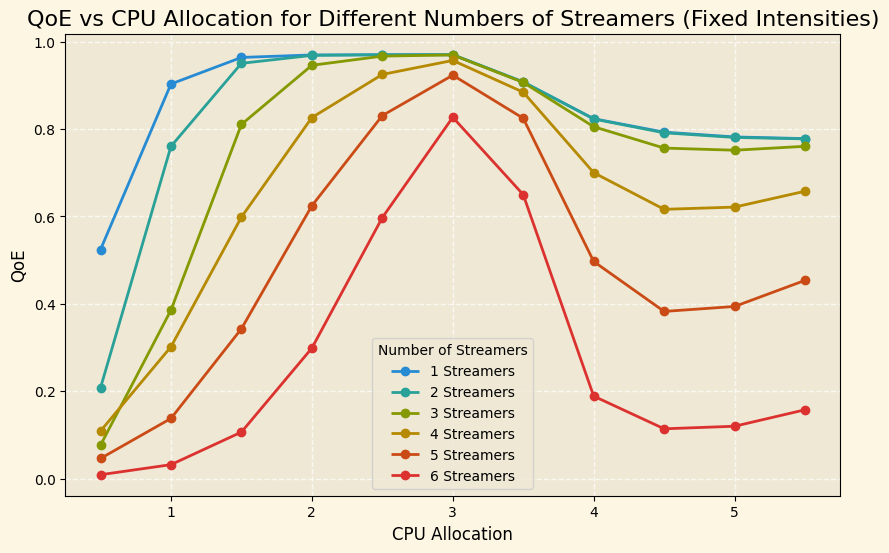

In [1568]:
# for intensity in range(100,5000):
results = {}

# Iterate over different numbers of streamers
for n_streamers in range(1, 7):
    qoe_list = []
    cpu_allocations = np.arange(0.5, 6.0, 0.5)
    
    # Iterate over CPU allocations from 0.5 to 5.5 in steps of 0.5
    for cpu in cpu_allocations:
        env = Environment(run_for=2, cpu_capacity=cpu)
        env.initialize_agent(num_servers=1, num_streamers=n_streamers, num_attackers=1)
        cur_qoe = env.run(intensity=1000)[1]
        qoe_list.append(cur_qoe)

    # Store QoE list in results dictionary for plotting
    results[n_streamers] = qoe_list

# Plotting
plt.figure(figsize=(10, 6))

# Plot each QoE line for different numbers of streamers
for n_streamers, qoe_list in results.items():
    plt.plot(cpu_allocations, qoe_list, marker='o', label=f'{n_streamers} Streamers')

# Labeling the plot
plt.title('QoE vs CPU Allocation for Different Numbers of Streamers (Fixed Intensities)')
plt.xlabel('CPU Allocation')
plt.ylabel('QoE')
plt.legend(title='Number of Streamers')
plt.grid(True)

# Show the plot
plt.show()

Before 0
Before 100
After 0
Before 0
Before 100
After 0
Before 0
Before 100
After 0
Before 0
Before 100
After 0
Before 0
Before 100
After 0
Before 0
Before 100
After 0
Before 0
Before 100
After 0
Before 0
Before 100
After 0
Before 0
Before 100
After 0
Before 0
Before 100
After 0
Before 0
Before 100
After 0
Before 0
Before 350
After 0
Before 0
Before 350
After 0
Before 0
Before 350
After 0
Before 0
Before 350
After 0
Before 0
Before 350
After 0
Before 0
Before 350
After 0
Before 0
Before 350
After 0
Before 0
Before 350
After 0
Before 0
Before 350
After 0
Before 0
Before 350
After 35.0
Before 0
Before 350
After 237.5
Before 0
Before 600
After 0
Before 0
Before 600
After 0
Before 0
Before 600
After 0
Before 0
Before 600
After 0
Before 0
Before 600
After 0
Before 0
Before 600
After 0
Before 0
Before 600
After 0
Before 0
Before 600
After 0
Before 0
Before 600
After 82.5
Before 0
Before 600
After 285.0
Before 0
Before 600
After 487.5
Before 0
Before 850
After 0
Before 0
Before 850
After 0
Be

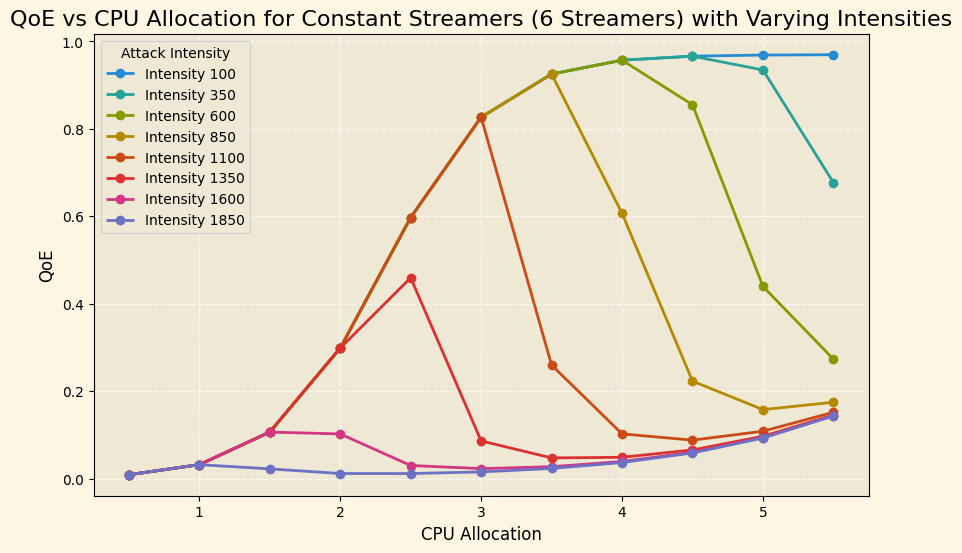

In [1570]:
# Set constant parameters
n_streamers = 6  # Constant number of streamers
cpu_allocations = np.arange(0.5, 6.0, 0.5)  # Range of CPU allocations
intensity_range = range(100, 2000, 250)  # Range of attack intensities

# Dictionary to store QoE results for each intensity level
results = {}

# Iterate over different intensities
for intensity in intensity_range:
    qoe_list = []
    
    # Iterate over CPU allocations from 0.5 to 5.5 in steps of 0.5
    for cpu in cpu_allocations:
        # Initialize environment with current CPU and constant streamers
        env = Environment(run_for=2, cpu_capacity=cpu)
        env.initialize_agent(num_servers=1, num_streamers=n_streamers, num_attackers=1)
        
        # Run the environment with current intensity and get QoE
        cur_qoe = env.run(intensity=intensity)[1]
        qoe_list.append(cur_qoe)
        

    # Store QoE list in results dictionary for plotting
    results[intensity] = qoe_list

# Plotting
plt.figure(figsize=(10, 6))

# Plot each QoE line for different attack intensities
for intensity, qoe_list in results.items():
    plt.plot(cpu_allocations, qoe_list, marker='o', label=f'Intensity {intensity}')

# Labeling the plot
plt.title(f'QoE vs CPU Allocation for Constant Streamers ({n_streamers} Streamers) with Varying Intensities')
plt.xlabel('CPU Allocation')
plt.ylabel('QoE')
plt.legend(title='Attack Intensity')
plt.grid(True)

# Show the plot
plt.show()

### Attack Intensity Modeling

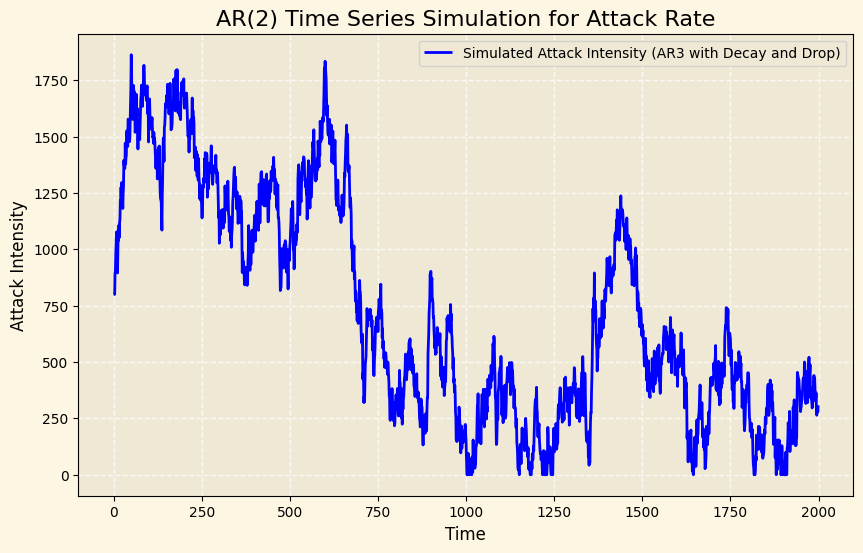

In [1564]:
import numpy as np
import matplotlib.pyplot as plt

def generate_attack_intensity(time_steps, baseline, fluctuation, spike_prob, spike_intensity, 
                                             persistence_coeffs, decay_factor, drop_prob, drop_intensity):
    # Initialize intensity array with the first three values set to baseline
    intensity = np.full(time_steps, baseline)
    
    # Generate time series with AR(3) process with decay and drop probability
    for t in range(3, time_steps):
        # AR(3) process with decay factor
        intensity[t] = (
            persistence_coeffs[0] * intensity[t - 1] +
            persistence_coeffs[1] * intensity[t - 2] +
            persistence_coeffs[2] * intensity[t - 3] +
            (1 - sum(persistence_coeffs)) * baseline +
            np.random.normal(0, fluctuation)
        )
        
        # Apply decay factor to gradually reduce intensity toward baseline
        # intensity[t] *= (1 - decay_factor)
        
        # Add random spikes
        if np.random.rand() < spike_prob:
            intensity[t] += spike_intensity
        
        # Randomly drop the intensity with a certain probability
        if np.random.rand() < drop_prob:
            intensity[t] -= drop_intensity
            # Ensure the intensity does not go below zero
            intensity[t] = max(intensity[t], baseline)
        intensity[t] = max(0, intensity[t])

    return intensity

# Parameters
time_steps = 2000
baseline_intensity = 800
fluctuation_intensity = 60
spike_prob = 0.0
spike_intensity = 200
persistence_coeffs = [0.85, 0.15, 0.0]  # Weights for AR(3)
decay_factor = 0.00 # Decay factor to bring intensity down gradually
drop_prob = 0.00  # Probability of a sudden drop in intensity
drop_intensity = 100  # Amount by which intensity drops if drop event occurs

# Generate intensity pattern for attack with AR(3), decay, and drop probability
intensity_series = generate_attack_intensity(
    time_steps, baseline_intensity, fluctuation_intensity, spike_prob, spike_intensity,
    persistence_coeffs, decay_factor, drop_prob, drop_intensity
)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(intensity_series, label="Simulated Attack Intensity (AR3 with Decay and Drop)", color="blue")
plt.xlabel("Time")
plt.ylabel("Attack Intensity")
plt.title("AR(2) Time Series Simulation for Attack Rate")
plt.legend()
plt.show()

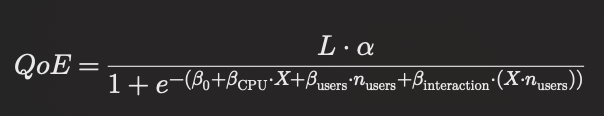

## QoE Distribution Without Attacks

In [1565]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# def logistic(X, beta_0, beta_1):
#     L = 0.85  
#     return L / (1 + np.exp(-(beta_0 + beta_1 * X)))

# # Parameters for different numbers of users
# qoe_vs_n_user_params = {
#     1: [-6.1664922,   7.32642948],
#     2: [-2.69486035,  2.53728771],
#     3: [-2.23382782,  1.16795435],
#     4: [-3.02220136,  1.29189061],
#     5: [-2.95189246,  1.25219137],
#     6: [-2.90428219,  0.94603565],
#     }
def generalized_logistic(X, L, alpha, beta_0, beta_CPU, beta_CPU_squared, beta_users, beta_interaction, n_users,atk):
    # Logistic function calculation with the specified regression equation
    linear_combination = (
        beta_0 
        + beta_CPU * X 
        # + beta_CPU_squared * (X ** 2) 
        + -1.5 * n_users #Increasing user will have negative effect on QoE
        + beta_interaction * (X * n_users) #Negative: diminishing return on CPU as the number of users increases
    )
    if atk == "none":
        L = 0.95
        L*(1-alpha*n_users)
    else:
        L = L*(1-alpha*n_users)
    # return L*(1-alpha*n_users) / (1 + np.exp(-linear_combination))
    return L / (1 + np.exp(-linear_combination))


def calculate_qoe(X, n_user,atk):
    """
    Calculates the QoE based on CPU allocation (X) and the number of users (n_user).
    """
    # params = qoe_vs_n_user_params[n_user]
    params = qoe_vs_n_user_params
    return generalized_logistic(X, *params, n_user, atk=atk)
def plot_qoe_distribution(qoe_vs_n_user_params, std_matrix,atk="none"):
    # Plotting setup
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows and 3 columns
    cpu_list = np.arange(0.5, 6, 0.5)  # Range of CPU values
    n_user_list = np.arange(1, 7)  # User counts from 1 to 6

    # Loop through each number of users to plot the QoE vs CPU
    for n_user in n_user_list:
        ax = axes[(n_user - 1) // 3, (n_user - 1) % 3]
        
        # Calculate QoE for each CPU value
        X = np.tile(cpu_list,(1000,1)).flatten()
        std_dev = [np.random.normal(0,std_matrix[n_user-1][int(i*2-1)]) for i in X]
        y = calculate_qoe(X, n_user,atk=atk) + std_dev
        y = np.clip(y,0,1)
        # Density estimation for color coding
        xy = np.vstack([X, y])
        density = gaussian_kde(xy)(xy)
        
        # Scatter plot with density-based colors
        sc = ax.scatter(X, y, c=density, s=density * 200, cmap='plasma', alpha=0.7)
        
        # Plot the logistic fit line
        ax.plot(cpu_list, calculate_qoe(cpu_list, n_user,atk=atk), color='black', linestyle='--', label='Logistic Fit')
        
        # Labels and titles for each subplot
        ax.set_xlabel('CPU')
        ax.set_ylabel('QoE')
        ax.set_xlim(0.4, 6)
        ax.set_ylim(0, 1)
        ax.set_title(f'{n_user} User(s)')
        ax.legend()

    # Colorbar for the density plot
    fig.colorbar(sc, ax=axes.ravel().tolist(), orientation='horizontal', label='Density')
    fig.suptitle('Density Map of QoE vs CPU for Users 1 to 6')
    plt.show()
# def attack_impact()



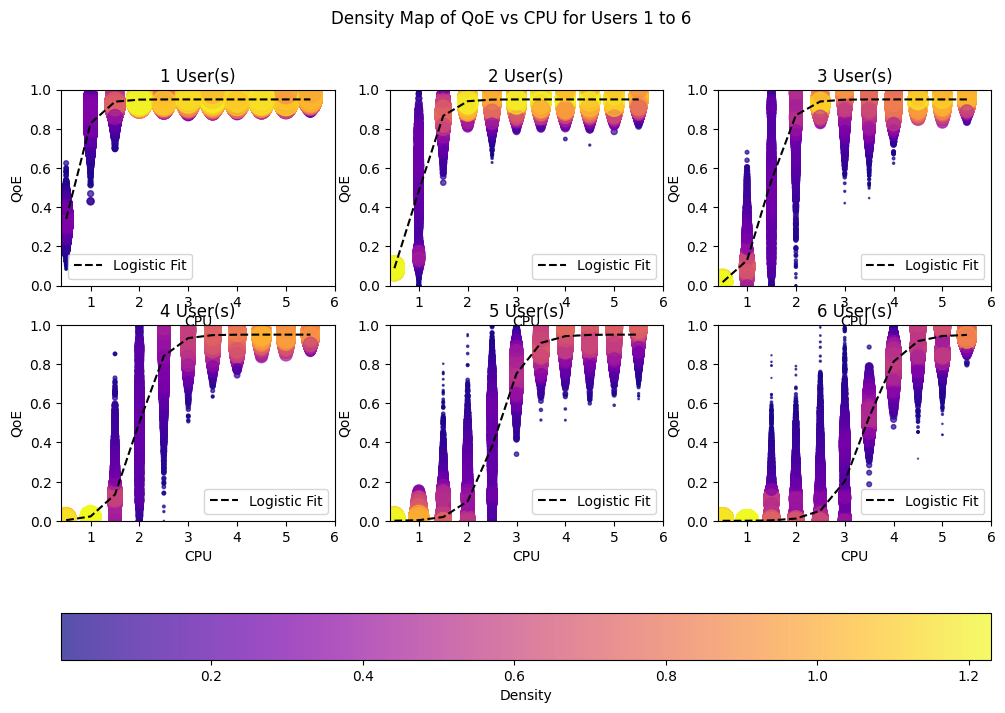

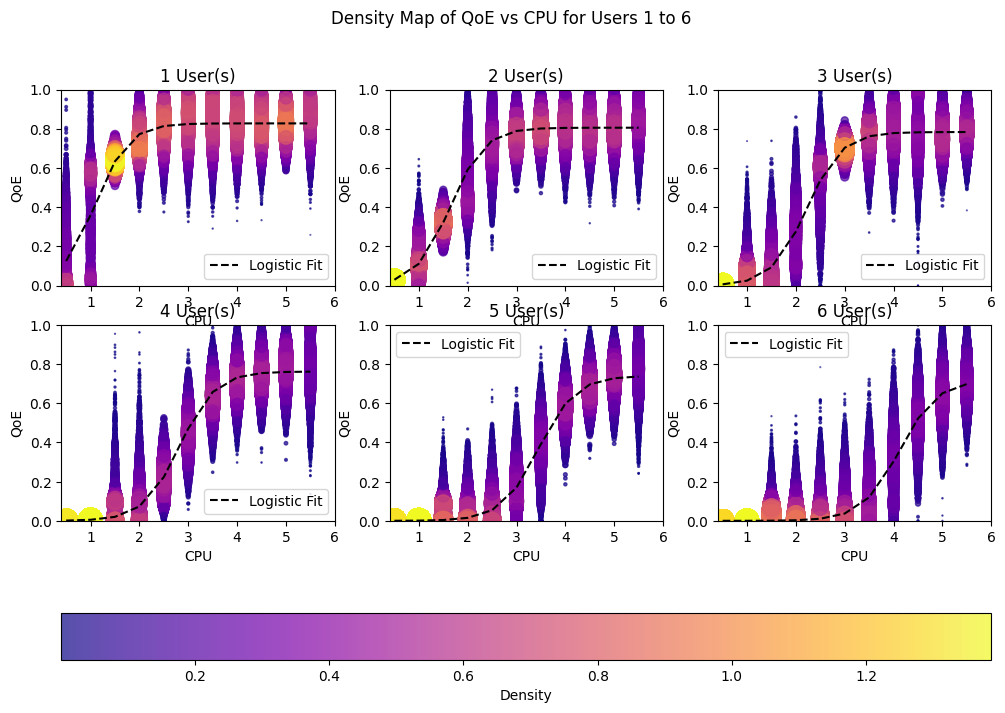

In [769]:
qoe_vs_n_user_params = [0.9527590553836042, 0.012356370194565059, -1.5753511198691, 5.370248138166865, -470.47100057345574, -0.8539269983355553, -0.38043183206411557]
#                       "L,     alpha,                  beta_0,                 beta_CPU,       beta_CPU_squared,  beta_users, beta_interaction"


std_matrix = [ # [User] [CPU * 2]
            [0.0902, 0.1282, 0.0794, 0.0151, 0.0227, 0.0241, 0.0221, 0.0205, 0.0205, 0.0205, 0.0205],
            [0.0050, 0.2217, 0.1078, 0.0451, 0.1111, 0.0493, 0.0493, 0.0493, 0.0493, 0.0493, 0.0493 ],
            [0.0050, 0.1800, 0.2824, 0.2959, 0.0377, 0.1578, 0.1578, 0.0964, 0.0364, 0.0364, 0.0348 ],
            [0.0050, 0.0000, 0.2355, 0.3006, 0.2886, 0.1364, 0.0975, 0.0629, 0.0325, 0.0325, 0.0325 ],
            [0.0050, 0.0478, 0.2645, 0.2917, 0.2898, 0.1224, 0.1113, 0.1113, 0.1113, 0.1113, 0.1113 ],
            [0.0050, 0.0000, 0.2680, 0.2680, 0.3473, 0.3473, 0.0956, 0.0956, 0.1527, 0.1527, 0.0387 ],
            ]
plot_qoe_distribution(qoe_vs_n_user_params, std_matrix,atk="none")
qoe_vs_n_user_params = [0.8497987262580884, 0.025954251123661228, -1.6793767808047577, 2.9774201662483755, -2355.033784310665, -0.71314329861917, -0.06426909430225365]
std_matrix = [
    [0.2571, 0.3391, 0.0421, 0.1339, 0.1339, 0.1621, 0.1621, 0.1470, 0.1470, 0.0971, 0.1573 ],
    [0.0000, 0.1678, 0.0547, 0.1975, 0.1975, 0.1055, 0.1055, 0.1334, 0.1334, 0.1319, 0.1409 ],
    [0.0000, 0.2132, 0.1842, 0.2146, 0.2146, 0.0435, 0.1451, 0.1451, 0.2314, 0.1161, 0.1095 ],
    [0.0000, 0.0000, 0.2698, 0.2698, 0.0964, 0.1292, 0.1292, 0.1378, 0.1265, 0.1265, 0.1943 ],
    [0.0000, 0.0000, 0.1611, 0.1611, 0.1826, 0.1586, 0.1586, 0.1218, 0.1149, 0.1149, 0.1786 ],
    [0.0000, 0.0000, 0.1544, 0.1544, 0.2106, 0.1976, 0.1976, 0.2186, 0.1769, 0.1769, 0.1373 ],    
]
plot_qoe_distribution(qoe_vs_n_user_params, std_matrix,atk="bonesi")

## Attack Impact Regression

0.97 -5.935 2.563
0.9444097778079391 -6.2481504509482075 2.1573026424025663
0.9323218127671988 -6.3960722499519065 1.9656647801381277
0.9239146728158413 -6.498951374923673 1.832381276868051
0.9215268245919522 -6.5281717444263165 1.794525266572207
0.9215000148362625 -6.5284998184469725 1.7941002352082942
0.9215000000000044 -6.528499999999945 1.7941000000000722
0.9215 -6.5285 1.7941


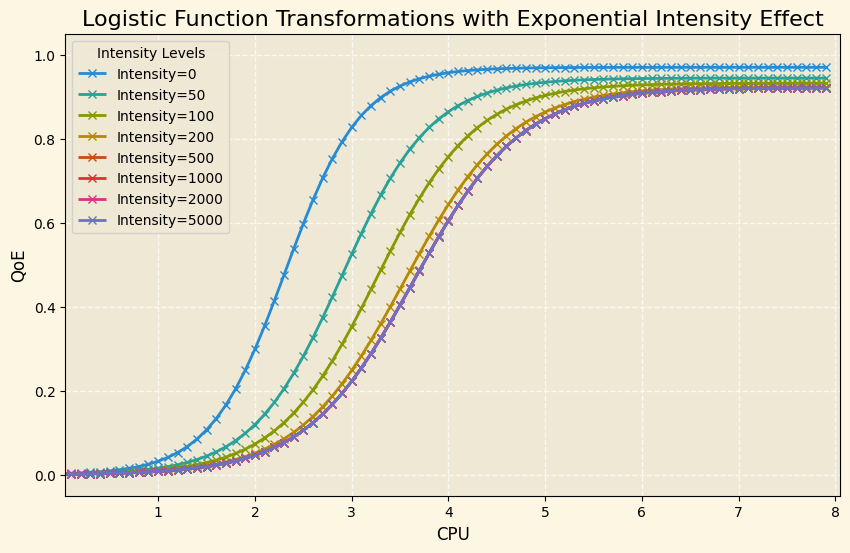

In [1571]:
import numpy as np
import matplotlib.pyplot as plt
'''
0,1,0.97, -2.2782716980482065, 4.8802368476587255
0,2,0.97, -3.8873078667967476, 5.175670954212056
0,3,0.97, -4.4959769724864636, 4.081147830542201
0,4,0.97, -3.3377765392197962, 2.5431386672697025
0,5,0.97, -4.186919060489949, 2.3893219975556157
0,6,0.97, -5.935630098896784, 2.56309746149014
'''

# Define the modified logistic function with exponential effect from intensity
def logistic(x, intensity, L_base=0.97, k=1.0, beta_0=-5.935, beta_CPU_base=2.563, alpha=0.015): #Follow The Regression Params from 0 Intensity
    # Define exponential saturation adjustment for intensity effect
    intensity_effect = 1 - np.exp(-alpha * intensity)
    
    # Adjust parameters based on intensity effect
    L = L_base * (1 - 0.05 * intensity_effect)  # Decrease L with intensity effect (saturates at ~0.5*L_base)
    beta_0 = beta_0 * (1 + 0.1 * intensity_effect)  # Decrease beta_CPU similarly
    beta_CPU = beta_CPU_base * (1 - 0.3 * intensity_effect)  # Decrease beta_CPU similarly
    print(L, beta_0, beta_CPU)
    return L / (1 + np.exp(-(beta_0 + beta_CPU * x)))

# Define the x values
x_values = np.arange(0, 8.0, 0.1)

# Define intensity levels for each curve (including high levels close to saturation)
intensity_levels = [0, 50, 100, 200, 500, 1000, 2000, 5000]  # Increasing intensity up to saturation point

# Plot each curve with different intensity levels
plt.figure(figsize=(10, 6))
for intensity in intensity_levels:
    y_values = logistic(x_values, intensity)
    plt.xlim(0.04,8.05)
    plt.plot(x_values, y_values, marker="x", label=f"Intensity={intensity}")

plt.xlabel("CPU")
plt.ylabel("QoE")
plt.title("Logistic Function Transformations with Exponential Intensity Effect")
plt.legend(title="Intensity Levels")
plt.ylim(-0.05, 1.05)
plt.show()

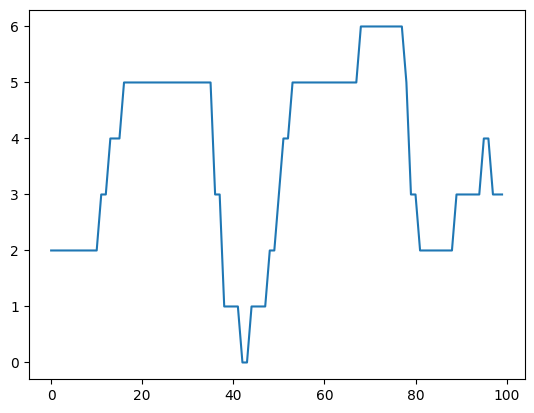

In [771]:

states = [0, 1] #0: Idle, #1: Streaming
duration_means = [10, 30]  # mean duration for each state (Poisson distribution)
transition_matrix = np.array([[0.3, 0.7],  # No Attack
                            [0.8, 0.2]])  # DDoS
run_for = 100
aggregate_state_sequence = np.zeros(run_for)
for i in range(6):
    aggregate_state_sequence += generate_hsmm(run_for, states, duration_means, transition_matrix, plot=False)
plt.plot(np.arange(0,100), aggregate_state_sequence)
    

In [772]:
lst_2d = [
            [0.25712348545527264, 0.33911919469246127, 0.04212710650213668, 0.1339139501975743, 0.16214160371739397, 0.14695509986705552, 0.09706234768913516, 0.1573228665430992],
            [0.0, 0.16776149062177662, 0.05473944036332018, 0.19754423646777744, 0.10546412829460602, 0.13338694854014368, 0.13192070146331786, 0.14094864186029196],
            [0.0, 0.2131670101966172, 0.18423653111825736, 0.21461896531828367, 0.0435186747497008, 0.1451253448360318, 0.23138286893381468, 0.1161038306146998, 0.10953127573754363],
            [0.0, 0.0, 0.2698168619086307, 0.0964342573470659, 0.1291926115870725, 0.13782875450956367, 0.12649719995030526, 0.1942525435924279],
            [0.0, 0.0, 0.16112754116326927, 0.18258126057892404, 0.1586045060516855, 0.12180655310633728, 0.11489072720433222, 0.17855862039007864],
            [0.0, 0.0, 0.1543581703877549, 0.2105807344860695, 0.19763371151411063, 0.21858807139399747, 0.176947244153546, 0.1373239115624134],
         ]
# Print each element in lst_2d with 4 decimal places
for row in lst_2d:
    formatted_row = ["{:.4f}".format(value) for value in row]
    print("[", end="")
    print(", ".join(formatted_row), "],")

[0.2571, 0.3391, 0.0421, 0.1339, 0.1621, 0.1470, 0.0971, 0.1573 ],
[0.0000, 0.1678, 0.0547, 0.1975, 0.1055, 0.1334, 0.1319, 0.1409 ],
[0.0000, 0.2132, 0.1842, 0.2146, 0.0435, 0.1451, 0.2314, 0.1161, 0.1095 ],
[0.0000, 0.0000, 0.2698, 0.0964, 0.1292, 0.1378, 0.1265, 0.1943 ],
[0.0000, 0.0000, 0.1611, 0.1826, 0.1586, 0.1218, 0.1149, 0.1786 ],
[0.0000, 0.0000, 0.1544, 0.2106, 0.1976, 0.2186, 0.1769, 0.1373 ],


/var/folders/fy/9jbbbrm52gjb_tgk0yfq90c40000gn/T/ipykernel_50019/1962032439.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap("seismic", 3)  # Get 3 colors from the 'seismic' colormap


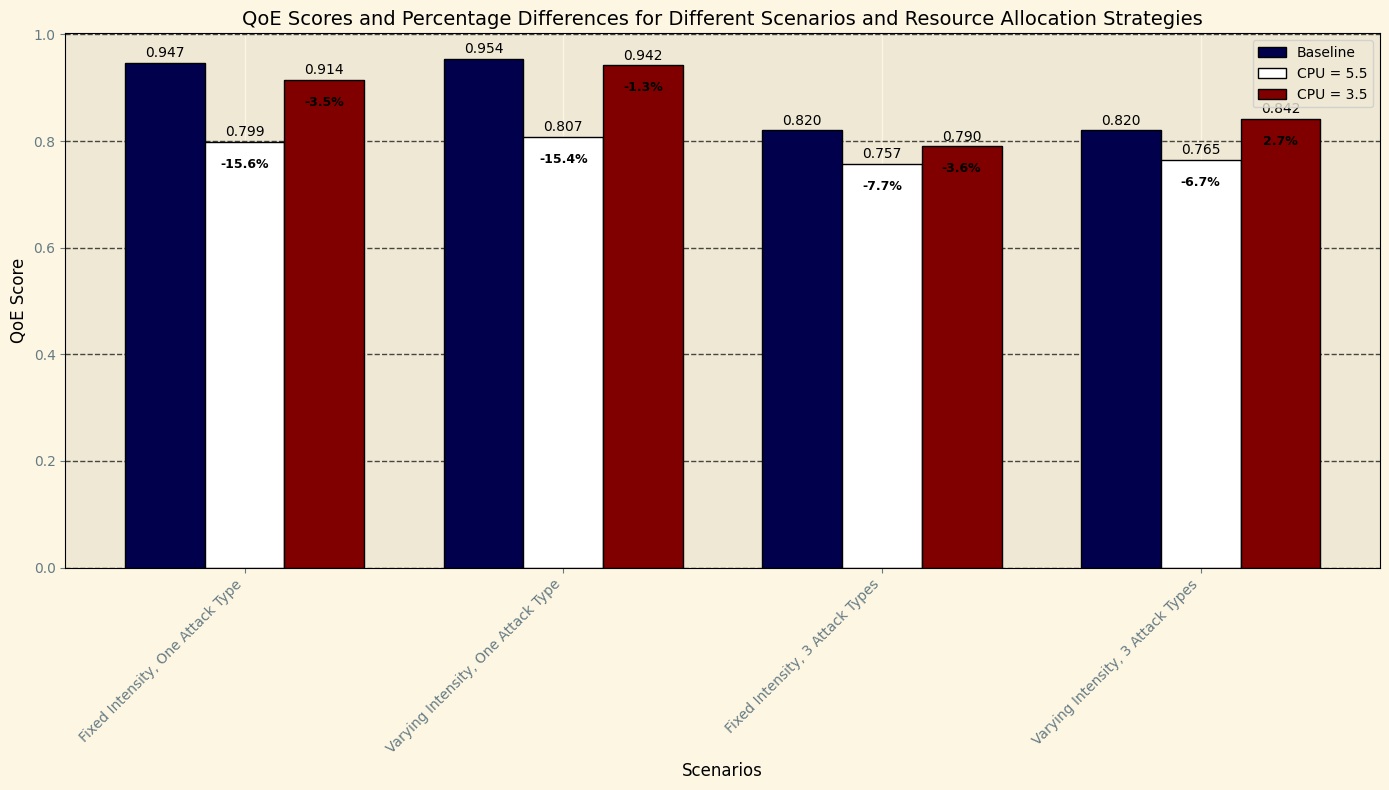

In [1544]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define the scenarios and QoE scores for each resource allocation strategy
scenarios = [
    "Fixed Intensity, One Attack Type",
    "Varying Intensity, One Attack Type",
    "Fixed Intensity, 3 Attack Types",
    "Varying Intensity, 3 Attack Types"
]
plt.style.use("Solarize_Light2")

# QoE scores for each resource allocation strategy
baseline_qoe = [0.9471, 0.9543, 0.8199, 0.8199]
cpu_5_5_qoe = [0.7989, 0.8075, 0.7568, 0.7647]
cpu_3_5_qoe = [0.9144, 0.9417, 0.7901, 0.8417]

# Set up the bar positions
x = np.arange(len(scenarios))  # the label locations
width = 0.25  # width of the bars

# Calculate percentage differences for annotation
def calculate_percentage_diff(reference, values):
    return [100 * (val - reference[i]) / reference[i] for i, val in enumerate(values)]

# Calculate percentage differences with Baseline as reference
cpu_5_5_diff = calculate_percentage_diff(baseline_qoe, cpu_5_5_qoe)
cpu_3_5_diff = calculate_percentage_diff(baseline_qoe, cpu_3_5_qoe)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))
color_map = cm.get_cmap("seismic", 3)  # Get 3 colors from the 'seismic' colormap

# Plot each resource allocation strategy
bars1 = ax.bar(x - width, baseline_qoe, width, label="Baseline", color=color_map(0), edgecolor="black")
bars2 = ax.bar(x, cpu_5_5_qoe, width, label="CPU = 5.5", color=color_map(1), edgecolor="black")
bars3 = ax.bar(x + width, cpu_3_5_qoe, width, label="CPU = 3.5", color=color_map(2), edgecolor="black")

# Annotate each bar with the QoE score
for i in range(len(scenarios)):
    ax.text(x[i] - width, baseline_qoe[i] + 0.005, f"{baseline_qoe[i]:.3f}", ha='center', va='bottom', fontsize=10)
    ax.text(x[i], cpu_5_5_qoe[i] + 0.005, f"{cpu_5_5_qoe[i]:.3f}", ha='center', va='bottom', fontsize=10)
    ax.text(x[i] + width, cpu_3_5_qoe[i] + 0.005, f"{cpu_3_5_qoe[i]:.3f}", ha='center', va='bottom', fontsize=10)

# Annotate percentage difference for CPU = 5.5 and CPU = 3.5 relative to Baseline
for i in range(len(scenarios)):
    ax.text(x[i], cpu_5_5_qoe[i] - 0.03, f"{cpu_5_5_diff[i]:.1f}%", ha='center', va='top', color="black", fontsize=9, fontweight="bold")
    ax.text(x[i] + width, cpu_3_5_qoe[i] - 0.03, f"{cpu_3_5_diff[i]:.1f}%", ha='center', va='top', color="black", fontsize=9, fontweight="bold")

# Labels, title, and legend
ax.set_xlabel("Scenarios", fontsize=12)
ax.set_ylabel("QoE Score", fontsize=12)
ax.set_title("QoE Scores and Percentage Differences for Different Scenarios and Resource Allocation Strategies", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=45, ha="right")
ax.legend()

# Add black grid lines for readability
ax.grid(axis="y", linestyle="--", color="black", alpha=0.7)
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
# Show plot with tight layout
plt.tight_layout()
plt.show()